https://www.kaggle.com/competitions/nlp-getting-started

# Проект: "предсказание типа комментариев: о реальных катастрофах и нереальных катастрофах."

# Импортирование библиотек

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable

import transformers
from transformers import BertModel, BertForSequenceClassification, BertTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

import re

import nltk
from tqdm import tqdm
import pickle
from collections import defaultdict

from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

import gc
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
device = torch.device('cuda')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Предварительный анализ и подготовка данных

In [35]:
train = pd.read_csv('bbc-text.csv')
train.columns = ['target', 'text']

In [36]:
train.head()

,target,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [37]:
print('Форма train: {}'.format(train.shape))

Форма train: (2225, 2)


In [38]:
print('{}'.format(train.info()), end = '\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  2225 non-null   object
 1   text    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None



Тестовая выборка меток не имеет, поэтому когда будем анализировать все данные без учета меток будем анализировать df = train + test, когда будет происходить анализ с учетом меток(например, их распределение), то будем использовать только train подвыборку. Пропусков в данных нету.

In [39]:
print('Всего меток твитов в данных: {}'.format(len(train['target'].unique())))
print('Уникальные метки твитов: {}'.format(train['target'].unique()), end = '\n\n')
print('Количество меток каждого типа твитов:\n{}'.format(train['target'].value_counts()))

Всего меток твитов в данных: 5
Уникальные метки твитов: ['tech' 'business' 'sport' 'entertainment' 'politics']

Количество меток каждого типа твитов:
target
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


Количество меток каждого типа твитов резко не отличаются, баланс классов примерно соблюдается.

# Предобработка данных

Итак, имеется исходный датафрейм df, в котором признак text соответствует твиту определенного пользователя, то есть это тип данных object, прежде чем приступить к работе с этими твитами, нужно нормализовать текст и каждый твит представить в виде набора нормализованных слов, а также убрать слишком часто встречающиеся слова и слишком редкие слова. 

## Понижение регистра слов

In [40]:
train['text'] = train['text'].str.lower()

## Исключение бесполезных слов и других бесполезных конструкций

### Исключение чисел и цифр

In [41]:
def number_remove(text):
    line = re.sub('\d+', '', text)
    return line

train['new_text'] = train['text'].apply(lambda x: number_remove(x))

### Исключение ссылок на сайты и html ссылок

In [42]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
train['new_text'] = train['new_text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

train['new_text']=train['new_text'].apply(lambda x:remove_html(x))

### Исключение пунктуационных знаков

In [43]:
def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

train['new_text']=train['new_text'].apply(lambda x:punct_remove(x))

### Исключение стоп-слов(слов, которые почти не характеризуют специфику конкретного текста)

In [44]:
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

train['new_text']=train['new_text'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Исключение хэштегов(#) и отсылок(@) в твитах

In [45]:
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
train['new_text']=train['new_text'].apply(lambda x:remove_hash(x))
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text

train['new_text']=train['new_text'].apply(lambda x:remove_mention(x))

### Удаление "длинных пробелов"(в случае, если при обработке таковые возникли)

In [46]:
def remove_space(text):
    space_remove = re.sub(r"\s+"," ", text).strip()
    return space_remove

train['new_text']=train['new_text'].apply(lambda x:remove_space(x))

# Удаление прочих ненужных конструкций

## Построение словаря

In [47]:
def build_dictionary(texts):
    
    dictionary = {}
    idx = 0
    
    for text in texts:
        for word in text.split():
            if word not in dictionary.keys():
                dictionary[word] = idx
                idx += 1
                
    return dictionary

In [48]:
def max_sequence_len(texts):
    max_len = 0
    
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len

In [49]:
dictionary = build_dictionary(train['new_text'])
max_seq_len = max_sequence_len(train['new_text'])
max_seq_len = 512 if max_seq_len > 512 else max_seq_len
    
print(f'Размер словаря: {len(dictionary)}')
print(f'Максимальное количество слов в предложении: {max_seq_len}')

Размер словаря: 30189
Максимальное количество слов в предложении: 512


## pretrained BERT model tokenization

In [50]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [51]:
# Load the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)
# bert = BertModel.from_pretrained('bert-base-cased')

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # Can be increased for multiclass 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
train_data, test_data = train_test_split(train, test_size=0.3, stratify=train["target"], random_state = 700)
valid_data, test_data  = train_test_split(test_data, test_size=0.5, random_state = 700)

# Построение предсказательной модели

In [53]:
class Dataset(torch.utils.data.Dataset):
    labels_dict = {'business':0,
                   'entertainment':1,
                   'sport':2,
                   'tech':3,
                   'politics':4}
              
    def __init__(self, df):

        self.labels = [self.labels_dict[label] for label in df['target']]
        self.texts = [bert_tokenizer(text, padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [54]:
train, valid, test = Dataset(train_data), Dataset(valid_data), Dataset(test_data)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=2)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=len(test))

In [71]:
valid.texts

In [55]:
torch.cuda.empty_cache()

In [56]:
gc.collect()

52

In [57]:
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [58]:
def train(model, train_dataloader, valid_dataloader, learning_rate, epochs):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in valid_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(valid_data): .3f} \
                | Val Accuracy: {total_acc_val / len(valid_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, train_dataloader, valid_dataloader, LR, EPOCHS)

100%|██████████| 779/779 [01:24<00:00,  9.25it/s]


Epochs: 1 | Train Loss:  0.788                 | Train Accuracy:  0.278                 | Val Loss:  0.694                 | Val Accuracy:  0.557


100%|██████████| 779/779 [01:25<00:00,  9.14it/s]


Epochs: 2 | Train Loss:  0.404                 | Train Accuracy:  0.857                 | Val Loss:  0.231                 | Val Accuracy:  0.958


100%|██████████| 779/779 [01:24<00:00,  9.22it/s]


Epochs: 3 | Train Loss:  0.150                 | Train Accuracy:  0.983                 | Val Loss:  0.106                 | Val Accuracy:  0.976


100%|██████████| 779/779 [01:24<00:00,  9.24it/s]


Epochs: 4 | Train Loss:  0.077                 | Train Accuracy:  0.988                 | Val Loss:  0.069                 | Val Accuracy:  0.982


100%|██████████| 779/779 [01:24<00:00,  9.27it/s]


Epochs: 5 | Train Loss:  0.044                 | Train Accuracy:  0.997                 | Val Loss:  0.055                 | Val Accuracy:  0.973


In [59]:
def evaluate(model, test_dataloader):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, test_dataloader)

Test Accuracy:  0.961


In [62]:
with open('bert_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [67]:
with open('STOPWORDS.pickle', 'wb') as f:
    pickle.dump(STOPWORDS, f)

In [72]:
with open('bert_tokenizer.pickle', 'wb') as f:
    pickle.dump(bert_tokenizer, f)

# Inference модели

In [133]:
class Inference:
    def __init__(self, texts, model, STOPWORDS, bert_tokenizer):
        
        """Тексты подаются в формате pandas Series"""
        
        self.texts = texts
        self.model = model
        self.stopwords = STOPWORDS
        self.bert_tokenizer = bert_tokenizer
        
    def preprocessing(self):
        def number_remove(text):
            line = re.sub('\d+', '', text)
            return line
        
        def remove_urls(text):
            url_remove = re.compile(r'https?://\S+|www\.\S+')
            return url_remove.sub(r'', text)
        
        def remove_html(text):
            html=re.compile(r'<.*?>')
            return html.sub(r'',text)

        def punct_remove(text):
            punct = re.sub(r"[^\w\s\d]","", text)
            return punct
        
        def remove_stopwords(text):
            return " ".join([word for word in str(text).split() if word not in self.stopwords])
        
        def remove_hash(x):
            text=re.sub(r'#\w+','',x)
            return text

        def remove_mention(x):
            text=re.sub(r'@\w+','',x)
            return text
        
        def remove_space(text):
            space_remove = re.sub(r"\s+"," ", text).strip()
            return space_remove
        
        self.texts_prep = self.texts.str.lower()
        self.texts_prep = self.texts_prep.apply(lambda x: number_remove(x))
        self.texts_prep = self.texts_prep.apply(lambda x: remove_urls(x))
        self.texts_prep = self.texts_prep.apply(lambda x: remove_html(x))
        self.texts_prep = self.texts_prep.apply(lambda x: punct_remove(x))
        self.texts_prep = self.texts_prep.apply(lambda x: remove_stopwords(x))
        self.texts_prep = self.texts_prep.apply(lambda x: remove_hash(x))
        self.texts_prep = self.texts_prep.apply(lambda x: remove_mention(x))
        self.texts_prep = self.texts_prep.apply(lambda x: remove_space(x))
        
    def to_bert_format(self):
        self.new_texts = [self.bert_tokenizer(text, padding='max_length', max_length = 512, truncation=True,
                                              return_tensors="pt") for text in self.texts_prep]
        
    def evaluate(self):
        device = torch.device("cuda")
        pred_probas = []
        pred_logits = []
        with torch.no_grad():
            for text in self.new_texts:
                mask = text['attention_mask'].to(device)
                input_id = text['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                pred_logits.append(output)
                
        pred_logits = [x.cpu().numpy().squeeze() for x in pred_logits]
        pred_probas = [1 / (1 + np.exp(-x)) for x in pred_logits]
        
        return pred_probas, pred_logits
    
    def run_eval(self):
        self.preprocessing()
        self.to_bert_format()
        self.predictions_proba, self.predictions_logit = self.evaluate()

In [134]:
data = pd.read_csv('bbc-text.csv')

In [136]:
inference_data = Inference(data['text'], model, STOPWORDS, bert_tokenizer)

In [137]:
inference_data.run_eval()

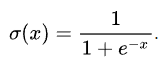